In [19]:
#!pip install graphviz
from typing import Union, Tuple, List, Set, Callable
from graphviz import Digraph
import math
import random

In [23]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        #dot.node(name=str(id(n)), label = "{ data %.4f | grad}" % (n.data), shape='record')

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [67]:
class Value:
    def __init__(self, data: Union[float, int], _children: Tuple["Value", ...]=(), _op: str="", label: str = "") -> None:
        """Initializes a scalar with its data."""
        self.data = float(data)
        self.grad = 0.0
        self.label = label

        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None


    def __repr__(self):
        """Returns a printable representation of the given Value object."""
        return f"Value(data={self.data})"


    def __add__(self, other: Union["Value", float, int]): 
        """Adds two Value objects (or a Value object with a Python int/float). e.g., self + other"""
        _other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + _other.data, _children = (self, _other), _op = "+")

        def _backward() -> None:
            """Going backwards through the computation graph, calculates the deriviates of the final node w.r.t. self and other (for this addition operation).
            Via the chain rule, self.grad = (the local derivative d(out)/d(self)) * (the gradient of out w.r.t. the final node (which was already calculated since we are going backward)).
            Via the chain rule, _other.grad = (the local derivative d(out)/d(_other)) * (the gradient of out w.r.t. the final node).
            The reason it is `+=` (instead of just `=`) is because each `self` and `_other` object could have been used for calculating many `out` objects, and so you need to add those gradients together.""" 
            self.grad += (1 * out.grad)     # local derivative for addition: d(out)/d(self) = 1
            _other.grad += (1 * out.grad)   # local derivative for addition: d(out)/d(_other) = 1
        out._backward = _backward

        return out

    def __mul__(self, other: Union["Value", float, int]):
        """Multiplies two Value objects (or a Value object with a Python int/float). e.g., self * other"""
        _other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * _other.data, _children = (self, _other), _op = "*")

        def _backward() -> None:
            """Going backwards through the computation graph, calculates the deriviates of the final node w.r.t. self and other (for this multiplication operation).""" 
            self.grad += (_other.data * out.grad)   # local derivative for multiplication: d(out)/d(self) = _other
            _other.grad += (self.data * out.grad)   # local derivative for multiplication: d(out)/d(_other) = self
        out._backward = _backward

        return out

    def __pow__(self, other: Union[float, int]):
        """The derivative expression would be different if we the power was another Value object. (it would be like x^y instead of x^2)"""
        assert isinstance(other, (float, int))
        _other = other
        out = Value(self.data ** _other.data, _children = (self, _other), _op = f"**{other}")

        def _backward() -> None:
            """Going backwards through the computation graph, calculates the deriviates of the final node w.r.t. self and other (for this multiplication operation).""" 
            self.grad += (_other * self.data**(_other -1)) * out.grad   # local derivative for multiplication: d(out)/d(self) = _other
            #_other.grad += ???   # WHAT IS THIS
        out._backward = _backward
        return out

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def __truediv__(self, other: Union["Value", float, int]):
        return self * other**(-1)



    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), _op = 'exp')

        def _backward() -> None:
            self.grad += out.data * out.grad    # local derivative of exp: d(out)/d(self) = 
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        tanh_x = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) 
        out = Value(tanh_x, _children = (self, ), _op = "tanh")

        def _backward() -> None:
            self.grad += (1 - tanh_x**2) * out.grad    # local derivative of tanh: d(out)/d(self) = 1 - tanh(selsf)^2
        out._backward = _backward

        return out

    def backward(self):
        """Calculates the gradients of the final node (self) w.r.t. each node."""
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()


    def __sub__(self, other):
        pass

    def __radd__(self, other: Union["Value", float, int]):
        """Adds a Python int/float with a Value object. e.g., other + self

        Without this method, if a command were `a = 2 + Value(3)`, a TypeError would occur 
        because Python does not know what to do with 2.__add__(Value(3))."""
        return self + other


    def __rmul__(self, other: Union["Value", float, int]):
        """Multiplies a Python int/float with a Value object. e.g., other * self

        Without this method, if a command were `a = 2 * Value(3)`, a TypeError would occur 
        because Python does not know what to do with 2.__mul__(Value(3))."""
        return self * other



In [70]:
class Neuron:
    def __init__(self, nin, layer_num = 0, node_num = 0):
        self.node_num = node_num
        self.layer_num = layer_num
        self.w = [Value(random.uniform(-1, 1), label=f"L{layer_num}w{prev_layer_node_num}-L{layer_num+1}w{node_num}") for prev_layer_node_num, _ in enumerate(range(nin))]
        self.b = Value(random.uniform(-1,1), label = f"L{layer_num+1}b{node_num}")
    
    def __call__(self, x):
        # w*x + b
        z = sum(xi*wi for wi, xi in zip(self.w, x)) + self.b
        z.label = f"L{self.layer_num+1}z{self.node_num}"
        out = z.tanh()
        out.label = f"L{self.layer_num+1}a{self.node_num}"
        return out

class Layer:
    def __init__(self, nin, nout, layer_num): 
        self.neurons = [Neuron(nin, layer_num, node_num) for node_num, _ in enumerate(range(nout))]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], layer_num) for layer_num, i in enumerate(range(len(nouts)))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


        

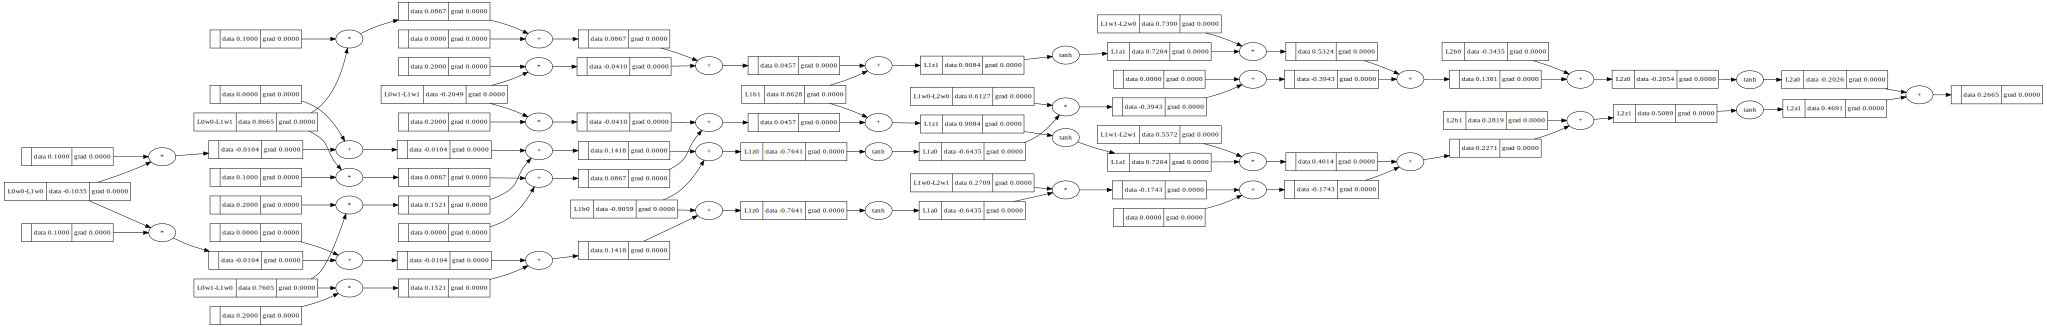

In [71]:
mlp = MLP(2, [2, 2])
x = [0.1, 0.2]
j = mlp(x)[0]
k = mlp(x)[1]
m = j + k
draw_dot(m)

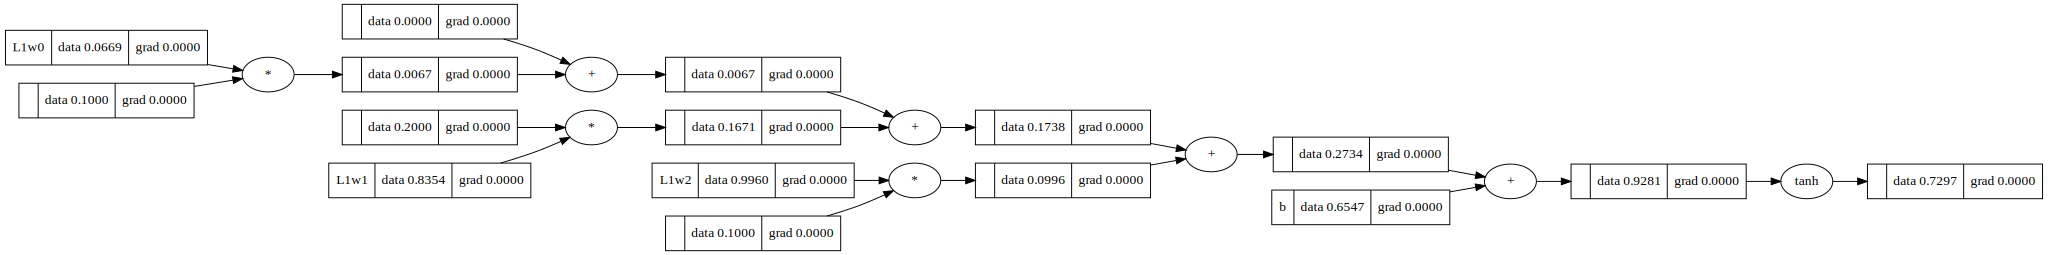

In [37]:
n = Neuron(3, "1")
x = [0.1, 0.2, 0.1]
o = n(x)
draw_dot(o)

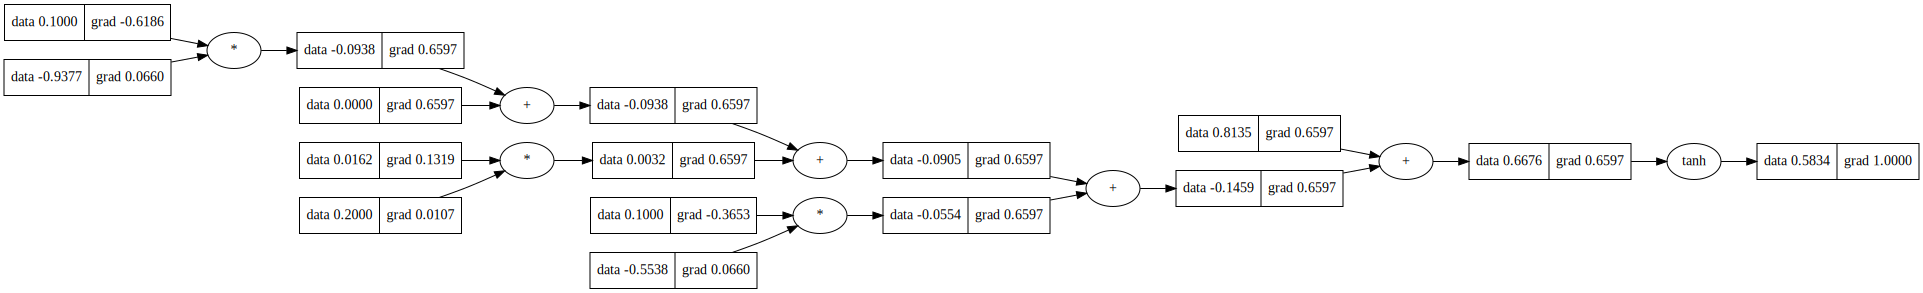

In [16]:
o.backward()
draw_dot(o)

In [4]:
a = Value(0.4)
b = Value(0.5)
c = a + b
d = 0.4 * c
e = d.tanh()


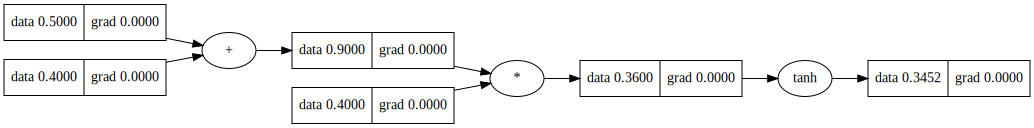

In [5]:
draw_dot(e)

In [21]:
e.grad = 1.0
e.backward()


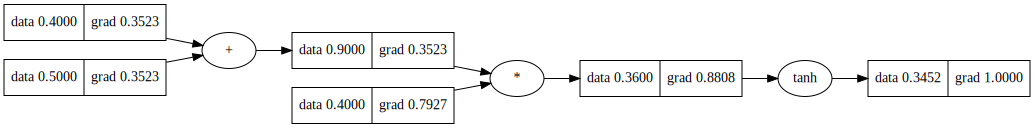

In [22]:
draw_dot(e)